In [2]:
import numpy as np
import os
import scipy
import matplotlib.pyplot as plt
import time
import matplotlib.patches as mpatches
import scipy.sparse.linalg
import seaborn as sns
from scipy.linalg import sqrtm
sns.set()
sns.set_style("whitegrid",  {"grid.linewidth": 0.6})
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
figsize = (8, 6)
marker_list = ['o', 'v', 's', 'P', '*', 'X', 'D']
cmap = plt.get_cmap("tab10")
cmap2 = plt.get_cmap("tab20")
fig_dir = os.path.join(os.getcwd(), 'cov_figs')
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)
verbose=True
show=True
save=False
lw=4
ls=20
fs=26
contour_cmap = plt.cm.get_cmap('Greys_r')
contour_points = 1000
density = 1.25
slw = 2.5
ms2=20
mew=2
ms=15
ms3=.5
fs2=24
lsp=0.1
htp=.1
frameon=False

## Game and Derivatives

In [3]:
def d1f1_func(V, W, reg1):
    return -(W + W.T)@V + reg1*V

def d1f1_func_scalar(V, W, reg1):
    return -(2*W)*V + reg1*V

def d2f2_func(V, W, S, reg2):
    return -(S - V@V.T) + reg2*W

def d2f2_func_scalar(V, W, S, reg2):
    return -(S - V*V) + reg2*W

def d21f2_func_scalar(V):    
    return 2*V

def d12f1_func_scalar(V):    
    return -2*V

def d11f1_func_scalar(W):
    return -2*W

def d22f2_func_scalar(reg2):
    return reg2*np.eye(1)

def J_tau_func_scalar(V, W, S, reg1, reg2, d, tau):
    d11f1 = d11f1_func_scalar(W)
    d12f1 = d12f1_func_scalar(V) 
    d21f2 = d21f2_func_scalar(V)
    d22f2 = d22f2_func_scalar(reg2)
    return np.vstack((np.hstack((d11f1, d12f1)), tau*np.hstack((d21f2, d22f2))))

## Run Dynamics

In [3]:
def run_dynamics(d1f1_func, d2f2_func, d, reg1=0.0, reg2=0.5, learning_rate=0.01, tau_list=[1, 4, 8, 16], num_epochs=4000):
    
    if d in [1]:
        np.random.seed(15)
    if d in [2]:
        np.random.seed(6)
    if d in [5]:
        np.random.seed(3)
    if d == 10:
        np.random.seed(11)
    elif d == 15:
        np.random.seed(18)

    U_init = np.random.randn(d,d)
    S_init = U_init@U_init.T
    S_init += np.eye(d)
    V_init = np.random.randn(d,d)
    W_init = np.random.randn(d,d)


    norm_trajectories = []
    trajectories = []
    trajectories_var = []
    for tau in tau_list:

        norm_trajectory = []
        trajectory = []
        trajectory_var = []

        S = S_init
        V = V_init
        W = W_init

        trajectory.append([V@V.T, W])
        trajectory_var.append([V, W])
        norm_trajectory.append([np.linalg.norm(S-V@V.T), np.linalg.norm(W+W.T)])

        start = time.time()

        for epoch in range(1, num_epochs+1):

            d1f1 = d1f1_func(V, W, reg1)
            d2f2 = d2f2_func(V, W, S, reg2)

            V = V - learning_rate * d1f1
            W = W - tau * learning_rate * d2f2

            trajectory.append([V@V.T, W])
            trajectory_var.append([V, W])
           # norm_trajectory.append([np.linalg.norm(S-V@V.T), np.linalg.norm(W+W.T)])
            norm_trajectory.append([np.linalg.norm(S-V@V.T), np.linalg.norm(W)])

        end = time.time()
        trajectories.append(trajectory)
        trajectories_var.append(trajectory_var)
        norm_trajectories.append(np.vstack(norm_trajectory))

    trajectories = np.array(trajectories)
    trajectories_var = np.array(trajectories_var)
    
    return trajectories, trajectories_var, norm_trajectories, S_init

## Plotting Functions

In [4]:
def plot_vector_field(trajectories_var, tau_list, d, name):

    x_min = np.min([trajectories_var[i][:, 0, 0, 0].min()  for i in range(len(tau_list))])-.75
    x_max = np.max([trajectories_var[i][:, 0, 0, 0].max()  for i in range(len(tau_list))])+.75
    y_min = np.min([trajectories_var[i][:, 1, 0, 0].min()  for i in range(len(tau_list))])-.75
    y_max = np.max([trajectories_var[i][:, 1, 0, 0].max()  for i in range(len(tau_list))])+.75

    xlims = [x_min, x_max]
    ylims = [y_min, y_max]

    fig, ax = plt.subplots(1, len(tau_list), figsize=(6*len(tau_list), 6), sharex=True, sharey=True)

    for count, tau in enumerate(tau_list):
        x, y = np.meshgrid(np.linspace(xlims[0],xlims[1], int(np.sqrt(contour_points))), np.linspace(ylims[0], ylims[1], int(np.sqrt(contour_points))))
        z1 = -d1f1_func_scalar(x, y, reg1)
        z2 = -tau*d2f2_func_scalar(x, y, S, reg2)
        z3 = np.sqrt(z1**2 + z2**2)
        z3 = z3/z3.max()
        ax[count].streamplot(x, y, z1, z2, color=z3, cmap=contour_cmap, density=density, linewidth=slw, arrowsize=2)
        trajectory = trajectories_var[count]
        ax[count].plot(trajectory[:, 0, 0, 0], trajectory[:, 1, 0, 0], color=cmap(count), lw=lw*2)
        ax[count].plot(trajectory[-1, 0, 0, 0], trajectory[-1, 1, 0, 0], color=cmap(count), markeredgecolor='black', marker='*', markersize=ms2, ls='none', markeredgewidth=mew)
        ax[count].plot(trajectory[0, 0, 0, 0], trajectory[0, 1, 0, 0], color=cmap(count), markeredgecolor='black', marker='o', markersize=ms, ls='none', markeredgewidth=mew)
        ax[count].set_xlim(xlims)
        ax[count].set_ylim(ylims)
        ax[count].tick_params(labelsize=ls)
        ax[count].set_xlabel(r'$\tau=%d$' % tau, fontsize=fs)

    fig.text(0.5, -0., '$V$', ha='center', fontsize=fs)
    fig.text(-0., 0.5, '$W$', va='center', rotation='vertical', fontsize=fs)
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(fig_dir, name + '_' + str(d)+'_vfield.png'), bbox_inches='tight')
    if show:
        plt.show()

        
def plot_distance_to_equilibria(norm_trajectories, d, name):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i in range(len(norm_trajectories)):
        plt.plot(norm_trajectories[i][:, 0], color=cmap(i), lw=lw)
        plt.plot(norm_trajectories[i][:, 1], color=cmap(i), lw=lw, ls='--')
    ax.set_yscale('log')
    ax.set_xlabel('Iterations', fontsize=fs)
    ax.tick_params(labelsize=ls)
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(fig_dir, name + '_' + str(d)+'_norm.png'), bbox_inches='tight')
    if show:
        plt.show()

        
def plot_eigs(tau_max, S, reg1, reg2, d, name):

    d = 1
    tau_min = 0.1
    tau_step = 0.1
    tau_sweep = np.arange(tau_min, tau_max, tau_step)
    eigs = [np.linalg.eigvals(J_tau_func_scalar(np.sqrt(S), np.zeros((d, d)), S, reg1, reg2, d, tau)) for tau in tau_sweep]
    eigs = np.vstack(eigs)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for i in range(2*d**2):
        ax.plot(np.real(eigs[:, i]), np.imag(eigs[:, i]), '-', lw=lw, color=cmap2(i), markersize=ms3, label=r'$\lambda_%d$'%(d+1))
        ax.plot(np.real(eigs[0, i]), np.imag(eigs[0, i]), color=cmap2(i), marker='o', markersize=ms2)
        ax.plot(np.real(eigs[-1, i]), np.imag(eigs[-1, i]), color=cmap2(i), marker='*', markersize=ms2)

    ax.set_ylabel(r'Img(spec($J_{\tau}$))', fontsize=fs)
    ax.set_xlabel(r'Re(spec($J_{\tau}$))', fontsize=fs)
    ax.tick_params(labelsize=ls)
    legend1 = ax.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp)

    l1, = ax.plot([], [], color='black', ls='none', marker='o', markersize=ms2)
    l2, = ax.plot([], [], color='black', ls='none', marker='*', markersize=ms2)
    legend2 = ax.legend([l1, l2], [r'$\tau=$'+str(tau_min), r'$\tau=$'+str(tau_max)], fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp, loc='lower right')

    ax.add_artist(legend1)
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(fig_dir, name+'_'+str(d)+'_tau_eig_sweep1.png'), bbox_inches='tight')
    if show:
        plt.show()

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    for i in range(2*d**2):
        ax.plot(tau_sweep, np.real(eigs[:, i]), '-', lw=lw, color=cmap2(i), markersize=ms3, label=r'Re($\lambda_%d$)'%(i+1))
        ax.plot(tau_sweep, np.imag(eigs[:, i]), '-', lw=lw, color=cmap2(i), markersize=ms3, label=r'Img($\lambda_%d)$'%(i+1), ls='--')

    ax.set_xlabel(r'$\tau$', fontsize=fs)
    ax.tick_params(labelsize=ls)
    ax.legend(fontsize=fs2, labelspacing=lsp, frameon=frameon, handletextpad=htp)
    plt.tight_layout()

    if save:
        plt.savefig(os.path.join(fig_dir, name + '_' +str(d)+'_tau_eig_sweep2.png'), bbox_inches='tight')
    if show:
        plt.show()

## Run Simulations

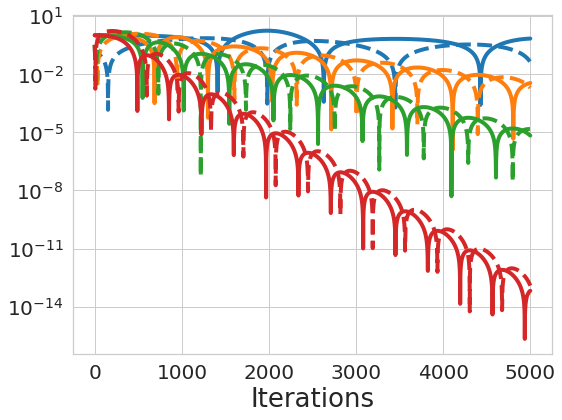

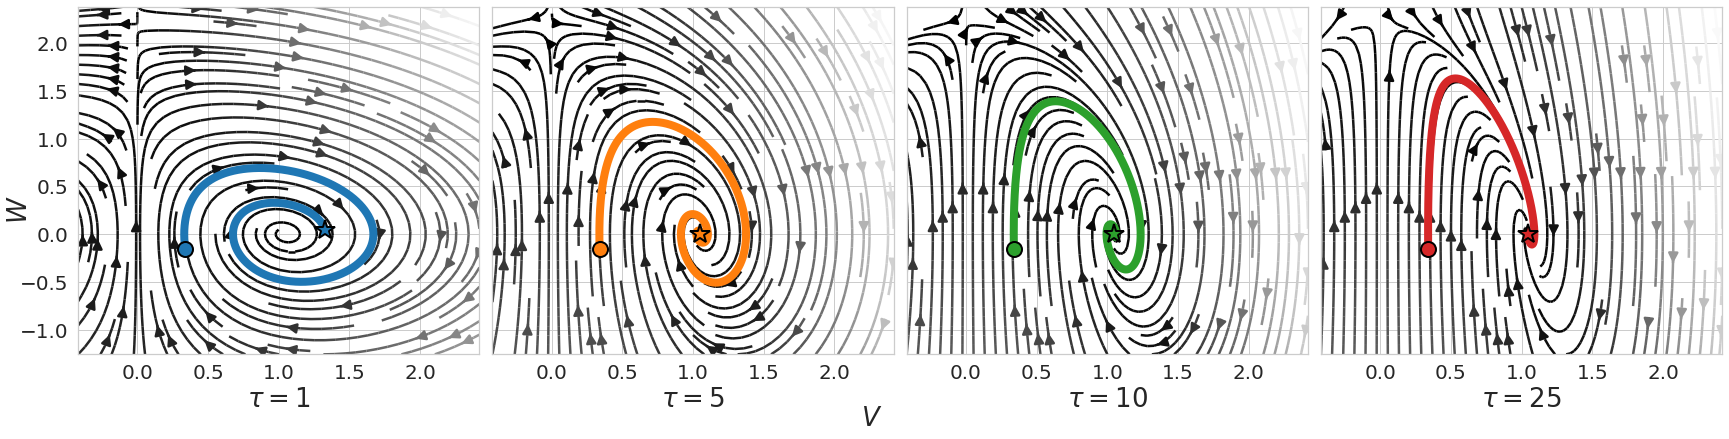

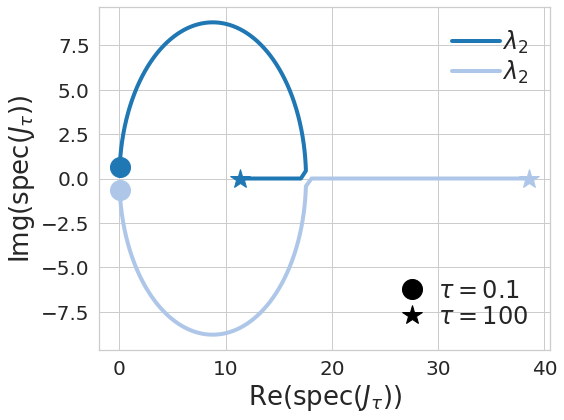

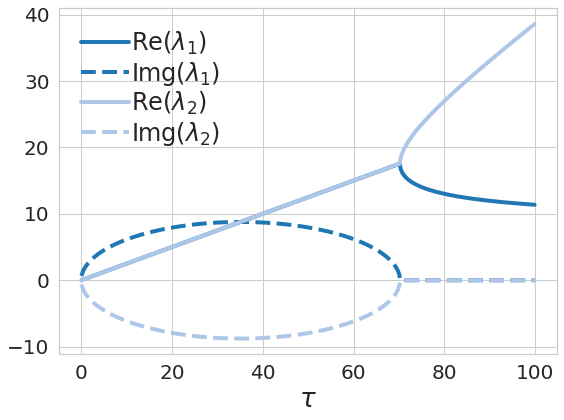

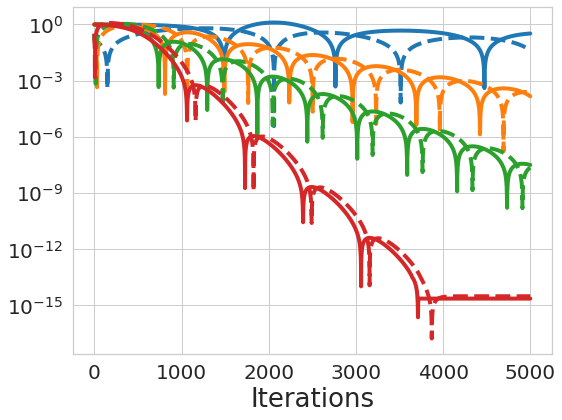

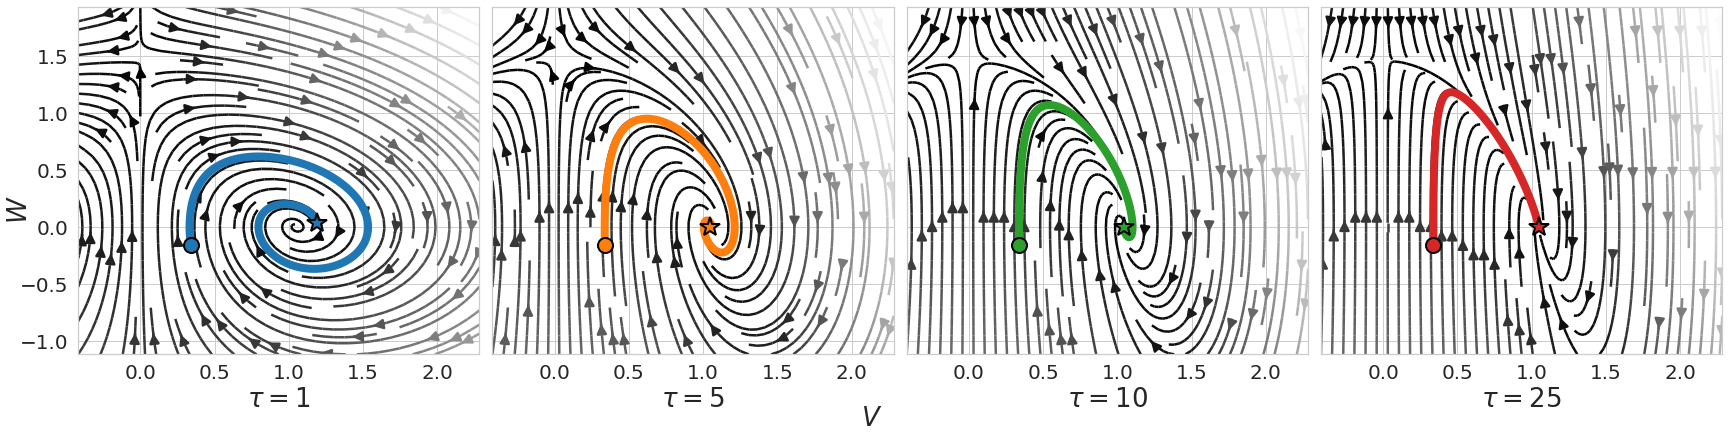

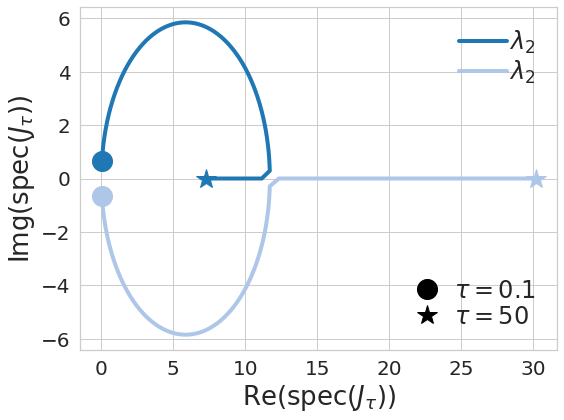

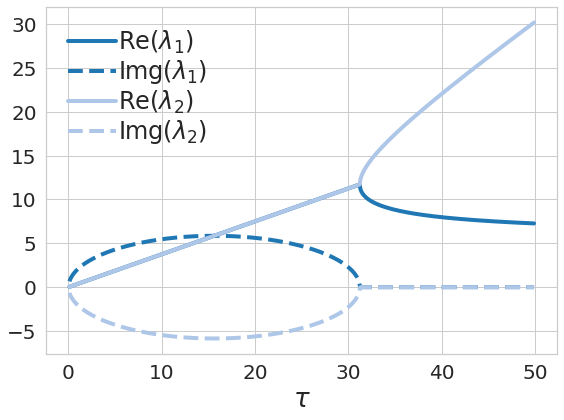

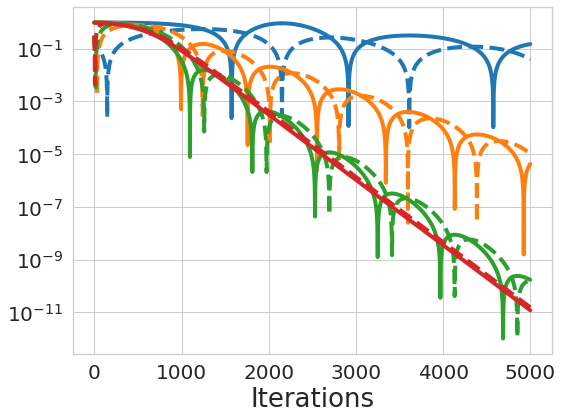

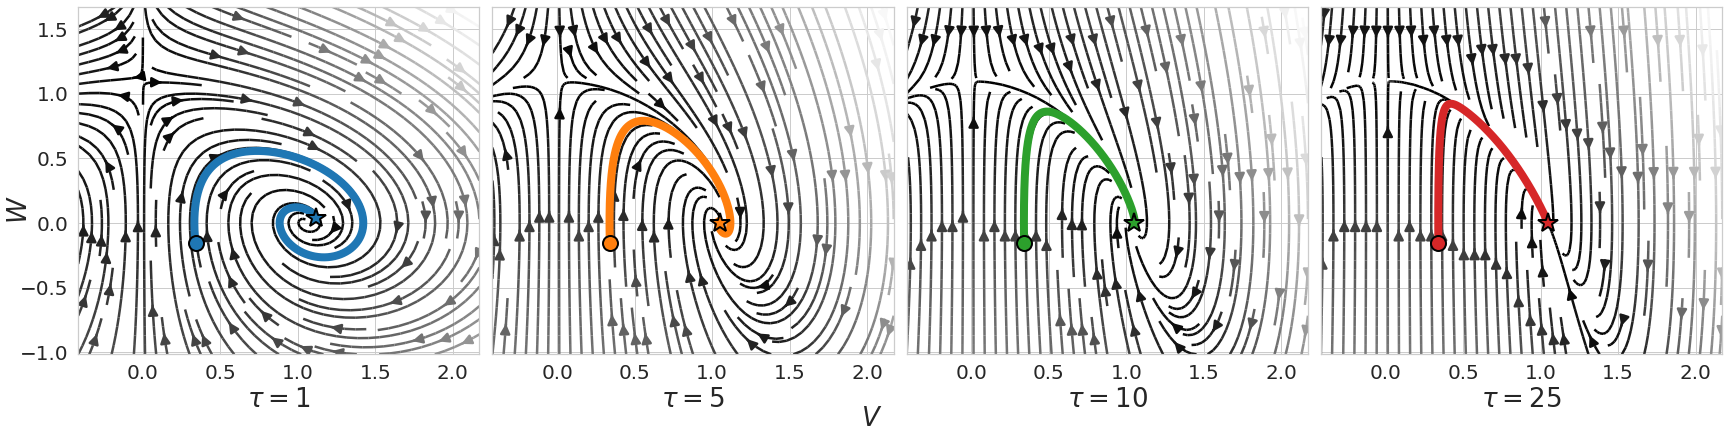

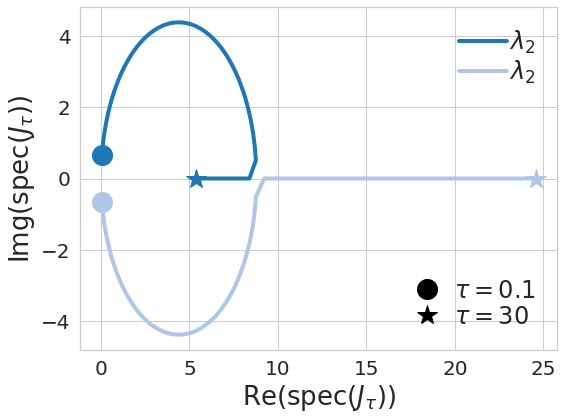

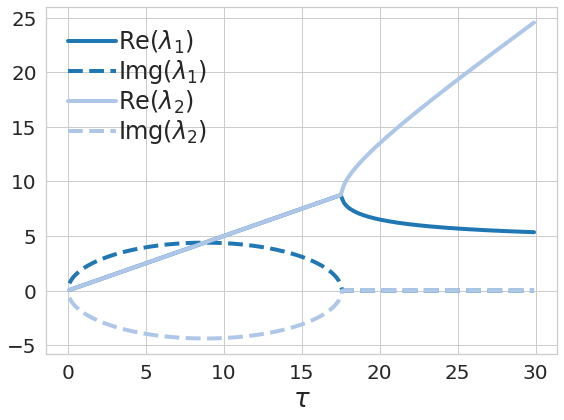

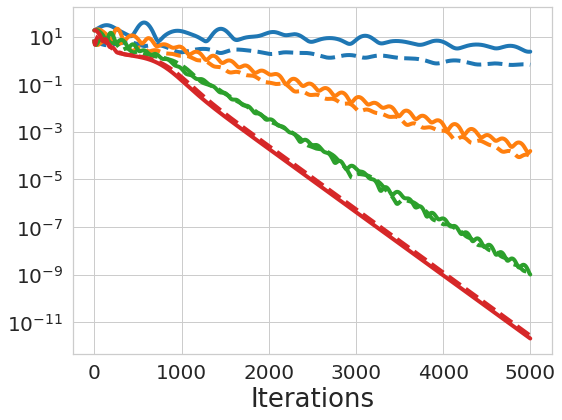

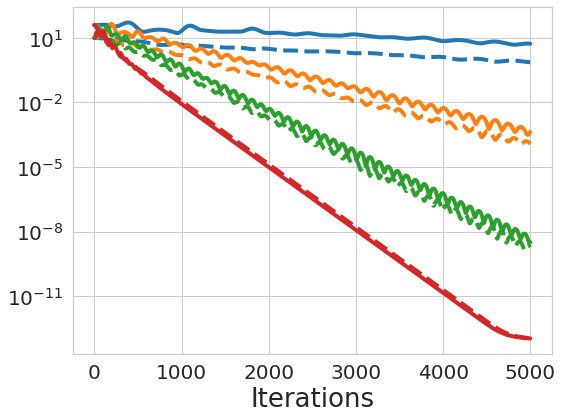

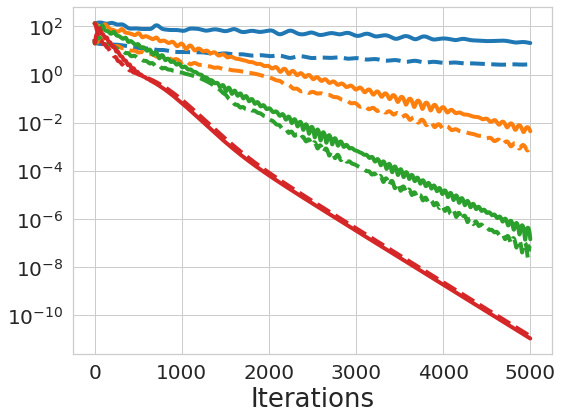

In [5]:
num_epochs = 5000
learning_rate = .001
reg1 = .0
reg2 = .5
tau_list = [1, 5, 10, 25]
d = 1
tau_max = 100
name = 'reg1'

trajectories, trajectories_var, norm_trajectories, S = run_dynamics(d1f1_func, d2f2_func, d, reg1=reg1, reg2=reg2, learning_rate=learning_rate, tau_list=tau_list, num_epochs=num_epochs)
plot_distance_to_equilibria(norm_trajectories, d=d, name=name)
plot_vector_field(trajectories_var, tau_list=tau_list, d=d, name=name)
plot_eigs(tau_max=tau_max, S=S, reg1=reg1, reg2=reg2, d=d, name=name)

num_epochs = 5000
freq = 10000
learning_rate = .001
reg1 = .0
reg2 = .75
tau_list = [1, 5, 10, 25]
d = 1
tau_max = 50
name = 'reg2'

trajectories, trajectories_var, norm_trajectories, S = run_dynamics(d1f1_func, d2f2_func, d, reg1=reg1, reg2=reg2, learning_rate=learning_rate, tau_list=tau_list, num_epochs=num_epochs)
plot_distance_to_equilibria(norm_trajectories, d=d, name=name)
plot_vector_field(trajectories_var, tau_list=tau_list, d=d, name=name)
plot_eigs(tau_max=tau_max, S=S, reg1=reg1, reg2=reg2, d=d, name=name)

num_epochs = 5000
freq = 10000
learning_rate = .001
reg1 = .0
reg2 = 1.
tau_list = [1, 5, 10, 25]
d = 1
tau_max = 30
name = 'reg3'

trajectories, trajectories_var, norm_trajectories, S = run_dynamics(d1f1_func, d2f2_func, d, reg1=reg1, reg2=reg2, learning_rate=learning_rate, tau_list=tau_list, num_epochs=num_epochs)
plot_distance_to_equilibria(norm_trajectories, d=d, name=name)
plot_vector_field(trajectories_var, tau_list=tau_list, d=d, name=name)
plot_eigs(tau_max=tau_max, S=S, reg1=reg1, reg2=reg2, d=d, name=name)


num_epochs = 5000
learning_rate = .001
reg1 = .0
reg2 = 1
tau_list = [1, 5, 10, 25]
d = 5
name = 'sim1'

trajectories, trajectories_var, norm_trajectories, S = run_dynamics(d1f1_func, d2f2_func, d, reg1=reg1, reg2=reg2, learning_rate=learning_rate, tau_list=tau_list, num_epochs=num_epochs)
plot_distance_to_equilibria(norm_trajectories, d=d, name=name)

num_epochs = 5000
learning_rate = .001
reg1 = .0
reg2 = 1
tau_list = [1, 5, 10, 25]
d = 10
tau_max = 400
name = 'sim2'

trajectories, trajectories_var, norm_trajectories, S = run_dynamics(d1f1_func, d2f2_func, d, reg1=reg1, reg2=reg2, learning_rate=learning_rate, tau_list=tau_list, num_epochs=num_epochs)
plot_distance_to_equilibria(norm_trajectories, d=d, name=name)

num_epochs = 5000
learning_rate = .001
reg1 = .0
reg2 = 1
tau_list = [1, 5, 10, 25]
d = 20
tau_max = 400
name = 'sim3'

trajectories, trajectories_var, norm_trajectories, S = run_dynamics(d1f1_func, d2f2_func, d, reg1=reg1, reg2=reg2, learning_rate=learning_rate, tau_list=tau_list, num_epochs=num_epochs)
plot_distance_to_equilibria(norm_trajectories, d=d, name=name)